In [1]:
# import necessary libraries
import pandas as pd 
import numpy as np
import pickle
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import keras_tuner as kt

import math

2025-08-10 11:48:45.541071: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 11:48:45.550501: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 11:48:45.624623: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 11:48:45.690990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754837325.752865   89835 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754837325.77

In [2]:
# load data
path = "datasets/"
test_data_file = "bp_sv_co_test_dataset.pkl"
train_data_file = "bp_sv_co_train_dataset.pkl"

train_data = pickle.load(open(f"{path}{train_data_file}", "rb"))
test_data = pickle.load(open(f"{path}{test_data_file}", "rb"))

In [3]:
# x and Y split
x_train = train_data[0]
y_train = train_data[1]

x_test = test_data[0]
y_test = test_data[1]

In [4]:
# Systolic
y_train_systolic = y_train[:,1]
y_test_systolic = y_test[:,1]

# Diastolic
y_train_diastolic = y_train[:,2]
y_test_diastolic = y_test[:,2]

# SV (systolic volume)
y_train_SV = y_train[:,3]
y_test_SV = y_test[:,3]

In [5]:
y_train.shape, x_train.shape

(torch.Size([4005, 5]), torch.Size([4005, 3, 100]))

In [6]:
def plot_features(x_train, sample_idx=0):
    """
    Plot the features of a sample.
    """

    # extract the sample from x_train
    sample = x_train[sample_idx]

    sample_dict = {
        "feature_1": sample[0],
        "feature_2": sample[1],
        "feature_3": sample[2],
    }

    sample_df = pd.DataFrame(sample_dict)

    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

    axs[0].plot(sample_df["feature_1"], color='blue')
    axs[0].set_title("Feature 1")
    axs[0].grid(True)

    axs[1].plot(sample_df["feature_2"], color='green')
    axs[1].set_title("Feature 2")
    axs[1].grid(True)

    axs[2].plot(sample_df["feature_3"], color='red')
    axs[2].set_title("Feature 3")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()



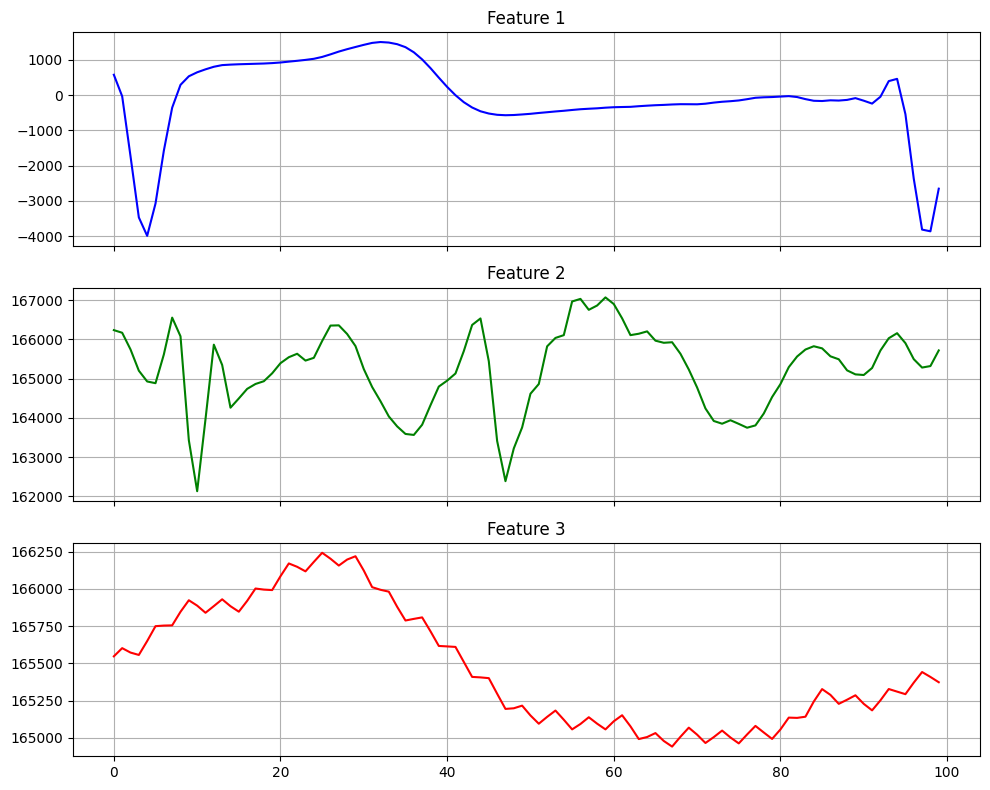

In [7]:
plot_features(x_train)

In [8]:
# transpose from (samples, features, time steps) to (samples, time steps, features)
x_train = x_train.permute(0, 2, 1).numpy()
x_test = x_test.permute(0, 2, 1).numpy()

In [9]:
x_train.shape, x_test.shape

((4005, 100, 3), (4045, 100, 3))

In [10]:
# keep only the relevant features for y_train and y_test
y_train = y_train[:, 1:4]
y_test = y_test[:, 1:4]

In [11]:
y_test

tensor([[109.0283,  46.9890, 119.9864],
        [106.5572,  46.6270, 119.9845],
        [105.3833,  47.7937, 119.9717],
        ...,
        [120.4249,  69.1176,  97.5701],
        [125.4908,  69.3416,  97.5909],
        [123.7914,  64.6130,  97.5829]])

In [12]:
y_train.shape, y_test.shape

(torch.Size([4005, 3]), torch.Size([4045, 3]))

In [13]:
# reshape to (samples*timesteps, features)
x_train_reshape = x_train.reshape(-1, 3) 
x_test_reshape = x_test.reshape(-1, 3)

# apply MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_train_scaled = scaler_x.fit_transform(x_train_reshape)
x_test_scaled = scaler_x.transform(x_test_reshape)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# get back to original shape
x_train_scaled = x_train_scaled.reshape(x_train.shape)
x_test_scaled = x_test_scaled.reshape(x_test.shape)

In [14]:
x_test_scaled.shape, x_train_scaled.shape, y_test_scaled.shape, y_train_scaled.shape

((4045, 100, 3), (4005, 100, 3), (4045, 3), (4005, 3))

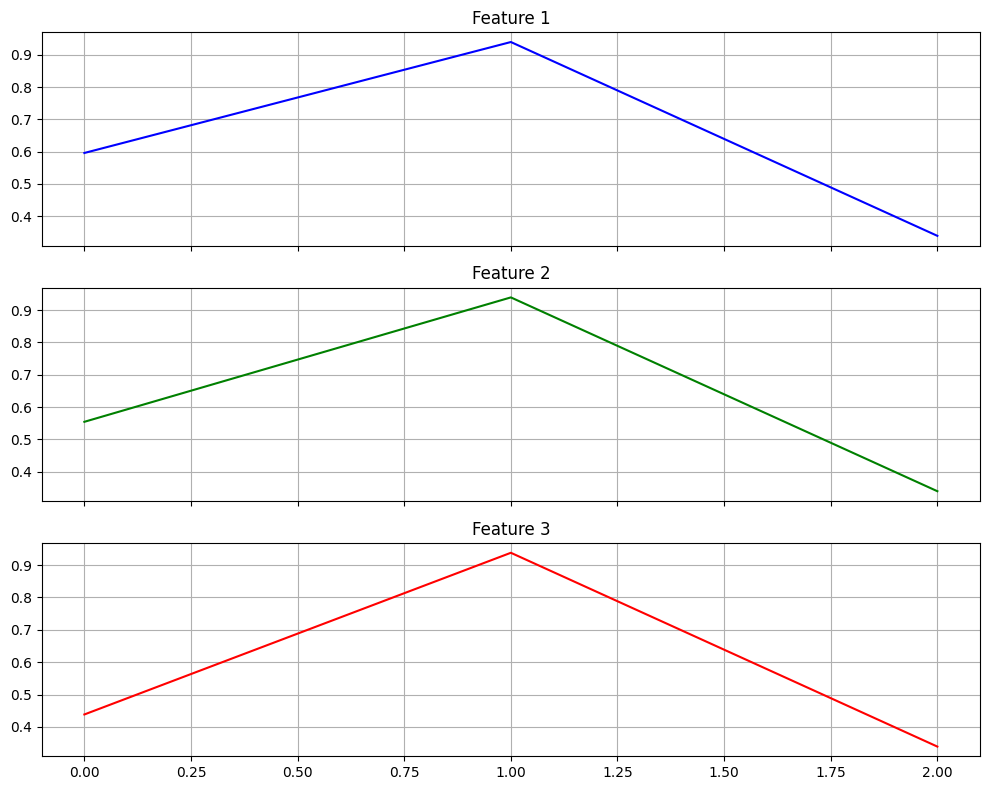

In [15]:
plot_features(x_train_scaled)

In [16]:
# define the model
model = Sequential([
    Input(shape=(100, 3)),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

2025-08-10 11:48:49.680192: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,403 (118.76 KB)

 Trainable params: 30,403 (118.76 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# early stopping callback
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

In [18]:
history = model.fit(
    x_train_scaled, y_train_scaled,
    validation_data=(x_test_scaled, y_test_scaled),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0423 - mae: 0.1603 - val_loss: 0.0497 - val_mae: 0.1686
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0199 - mae: 0.1135 - val_loss: 0.0522 - val_mae: 0.1717
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0131 - mae: 0.0904 - val_loss: 0.0464 - val_mae: 0.1591
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0115 - mae: 0.0837 - val_loss: 0.0448 - val_mae: 0.1587
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0110 - mae: 0.0821 - val_loss: 0.0422 - val_mae: 0.1581
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0109 - mae: 0.0812 - val_loss: 0.0486 - val_mae: 0.1645
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0102 - mae: 0.0780 - val_loss: 0.0443 - val_mae: 0.1566
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0102 - mae: 0.0782 - val_loss: 0.0433 - val_mae: 0.1561
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/

In [19]:
loss, mae = model.evaluate(x_test_scaled, y_test_scaled)
print(f'Test Loss: {loss:.4f} - Test MAE: {mae:.4f}')

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0413 - mae: 0.1490
Test Loss: 0.0413 - Test MAE: 0.1490


In [20]:
# make predictions
train_prediction = model.predict(x_train_scaled)
test_prediction = model.predict(x_test_scaled)

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [21]:
# rescale predictions
train_prediction = scaler_y.inverse_transform(train_prediction)
test_prediction = scaler_y.inverse_transform(test_prediction)

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train, train_prediction))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test, test_prediction))
print('Test Score: %.2f RMSE' % (test_score))


Train Score: 8.62 RMSE
Test Score: 16.34 RMSE


In [22]:
def plot_predictions(test_prediction, y_test):
    """
    Plot the features of a sample.
    """

    test_dict = {
        "Systolic": y_test[:, 0],
        "Diastolic": y_test[:, 1],
        "SV": y_test[:, 2],
    }

    prediction_dict = {
        "Systolic": test_prediction[:, 0],
        "Diastolic": test_prediction[:, 1],
        "SV": test_prediction[:, 2],
    }

    test_df = pd.DataFrame(test_dict)
    prediction_df = pd.DataFrame(prediction_dict)


    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

    axs[0].plot(test_df["Systolic"], color='blue')
    axs[0].plot(prediction_df["Systolic"], color='#1f77b4')
    axs[0].set_title("Systolic")
    axs[0].grid(True)

    axs[1].plot(test_df["Diastolic"], color='green')
    axs[1].plot(prediction_df["Diastolic"], color='#2ca02c')
    axs[1].set_title("Diastolic")
    axs[1].grid(True)

    axs[2].plot(test_df["SV"], color='red')
    axs[2].plot(prediction_df["SV"], color='#EF4026')
    axs[2].set_title("SV")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

In [23]:
test_prediction

array([[123.39772 ,  63.144127,  97.81682 ],
       [127.33616 ,  66.01819 ,  95.55243 ],
       [130.74376 ,  68.69754 ,  94.83777 ],
       ...,
       [126.74453 ,  66.51694 , 103.08984 ],
       [126.50467 ,  66.318954, 103.0706  ],
       [125.863335,  67.385254, 102.25281 ]], dtype=float32)

In [24]:
y_test

tensor([[109.0283,  46.9890, 119.9864],
        [106.5572,  46.6270, 119.9845],
        [105.3833,  47.7937, 119.9717],
        ...,
        [120.4249,  69.1176,  97.5701],
        [125.4908,  69.3416,  97.5909],
        [123.7914,  64.6130,  97.5829]])

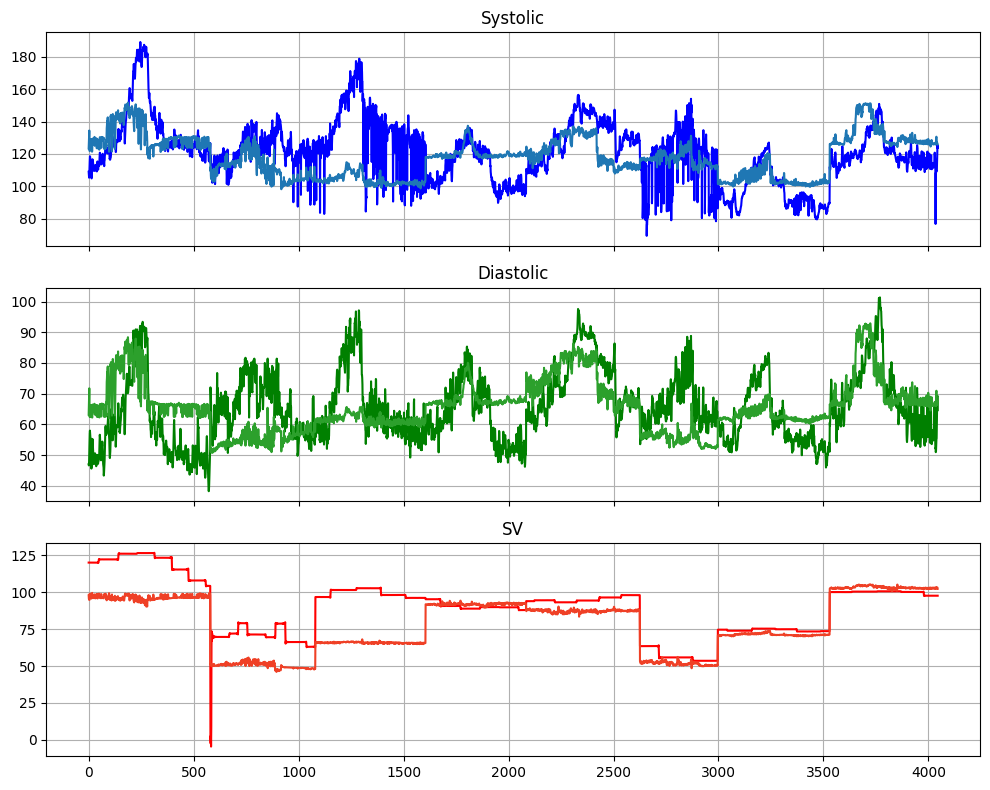

In [25]:
plot_predictions(test_prediction, y_test)

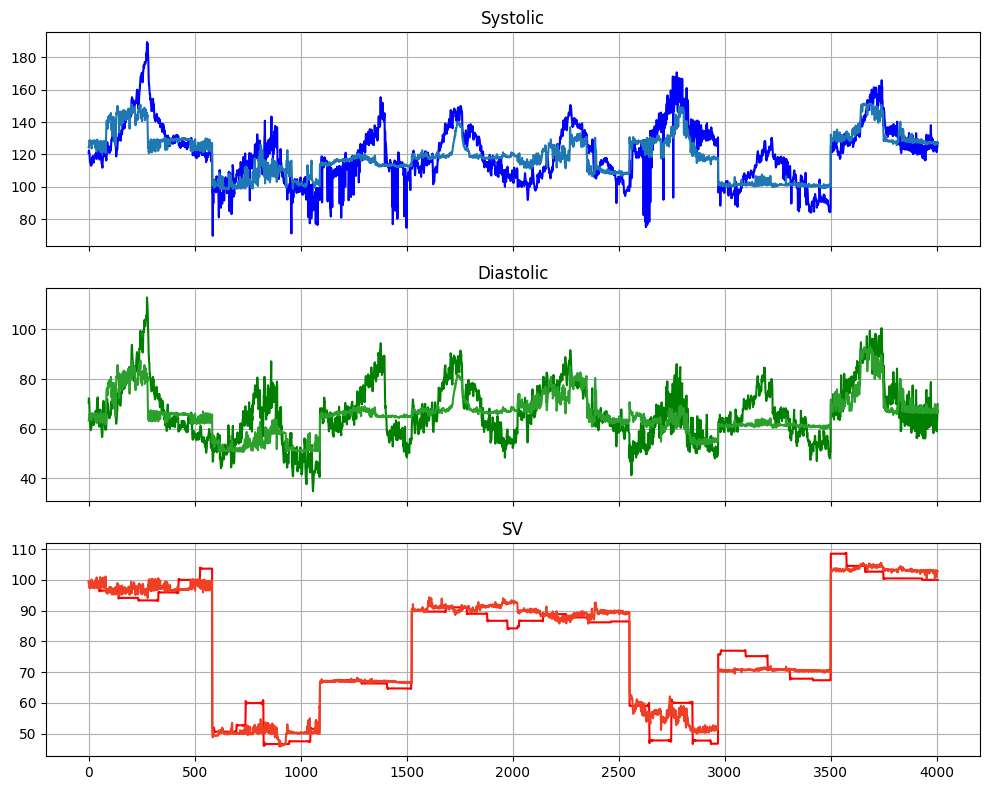

In [26]:
plot_predictions(train_prediction, y_train)

In [30]:
# build model for hyperparameter tuning
def model_builder(hp):
  """Builds and compiles an LSTM-based regression model for hyperparameter tuning.

    This function creates a Keras Sequential model for time series regression 
    tasks. The architecture includes one or two LSTM layers (tunable), a dense 
    hidden layer, and an output layer for multi-output regression. Several 
    hyperparameters are optimized via Keras Tuner, including:
    
    - Number of LSTM layers (1 or 2)
    - Units in each LSTM layer
    - Units in the dense hidden layer
    - Learning rate for the Adam optimizer

    Args:
        hp (kerastuner.HyperParameters): Hyperparameter search space object 
            used to define tunable parameters such as layer sizes and learning rate.

    Returns:
        keras.Model: A compiled Keras Sequential model ready for training 
            and hyperparameter tuning.
    """
  
  model = keras.Sequential()
  model.add(Input(shape=(100, 3)))

  # tune the number of LSTM layers
  num_lstm_layers = hp.Int('num_lstm_layers', min_value=1, max_value=2)
    
  # first LSTM layer
  # Choose an optimal value between 16-512
  units_layer_1 = hp.Int('units_layer_1', min_value=16, max_value=512, step=16)
  model.add(LSTM(units=units_layer_1, activation='tanh', return_sequences=(num_lstm_layers > 1)))
    
  # second LSTM layer (optional)
  if num_lstm_layers > 1:
      # Choose an optimal value between 16-256
      units_layer_2 = hp.Int('units_layer_2', min_value=16, max_value=256, step=16)
      model.add(LSTM(units=units_layer_2, activation='tanh'))

  # Choose an optimal value between 16-128
  units_layer_3 = hp.Int('units_layer_3', min_value=16, max_value=128, step=16)
  model.add(Dense(units=units_layer_3, activation='relu'))
  model.add(Dense(units=3, activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mae'])

  return model

In [31]:
# initialize the tuner
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss',
                     max_epochs = 100,
                     factor = 3,
                     project_name = 'blood_pressure_estimator')

In [ ]:
tuner.search(x_train_scaled, y_train_scaled, epochs=500, callbacks=[early_stop], validation_data=(x_test_scaled, y_test_scaled))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_lstm_layers')}. The optimal number of units in each of the densely-connected
layers is {(best_hps.get('units_layer_1'), best_hps.get('units_layer_2'), best_hps.get('units_layer_3'))} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 5 Complete [00h 00m 31s]
val_loss: 0.04221346974372864

Best val_loss So Far: 0.041189126670360565
Total elapsed time: 00h 02m 08s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
1                 |2                 |num_lstm_layers
416               |32                |units_layer_1
128               |128               |units_layer_3
0.01              |0.001             |learning_rate
16                |16                |units_layer_2
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.6389 - mae: 0.4260